In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import re
from Bio.Data import CodonTable
import textwrap
import ast
import scipy.stats as stats
standard_table = CodonTable.unambiguous_dna_by_id[1]

def readUsearchOutputTodf(filename):
    df_usearch = pd.read_csv(filename,delimiter='\t',\
                             names=['query','target','id','alnlen','mism','opens','qlo','qhi',\
                                    'tlo','thi','evalue','bits','qrow','trow','qrowdots','tstrand','qstrand']) 
    return df_usearch
def findMutInString(query):
    list_A = [m.start() for m in re.finditer('A',query )]
    list_T = [m.start() for m in re.finditer('T',query )]
    list_C = [m.start() for m in re.finditer('C',query )]
    list_G = [m.start() for m in re.finditer('G',query )]
    return {'A':list_A,'T':list_T,'C':list_C,'G':list_G}
    

def convertUsearchToValueCounts(inputFileName,countColumnName):
    """
    The following function converts the usearch input into a valu counts output
    The goal of the function is to reduce the usearch dataframes into simple readable value counts
    
    Input: inputFileName
    Output: a dataframe with read counts
    """
    df = readUsearchOutputTodf('Usearch/'+inputFileName+'.fastq.txt')
    series = df.qrowdots.value_counts()
    df_value_counts = pd.DataFrame(series)
    df_value_counts.columns = [countColumnName]
    df_value_counts['qrowdots'] = df_value_counts.index.values
    df_value_counts = df_value_counts.set_index(np.arange(0,len(series),1))
    df_value_counts = df_value_counts[['qrowdots',countColumnName]]
    return df_value_counts

def getMutationList(Mutations_Position):
    target = 'caacccgctgtctgagattacgcacaaacgtcgtatctccgcactcggcccaggcggtctgacccgtgaacgtgcaggcttcgaagttcgagacgtacacccgactcactacggtcgcgtatgtccaatcgaaacccctgaaggtccgaacatcggtctgatcaactctctgtccgtgtacgcacagactaacgaatacggcttccttgagactccgtatcgtaaagtgaccgacggtgttgtaactgacgaaattcactacctgtctgcnnnnn'
    target_list = list(target)
    mutation = ''
    if type(Mutations_Position) == str:
        Mutations_Position = ast.literal_eval(Mutations_Position)
    for key in Mutations_Position.keys():
        if len(Mutations_Position[key]) > 0:
            for position in Mutations_Position[key]:
                mutation = mutation + target[position].upper()+str(position)+ key +','
    return mutation[:-1]

def codonChange(Mutations):
    if pd.isnull(Mutations) == False:
        try:
            coding_seq = 'aacccgctgtctgagattacgcacaaacgtcgtatctccgcactcggcccaggcggtctgacccgtgaacgtgcaggcttcgaagttcgagacgtacacccgactcactacggtcgcgtatgtccaatcgaaacccctgaaggtccgaacatcggtctgatcaactctctgtccgtgtacgcacagactaacgaatacggcttccttgagactccgtatcgtaaagtgaccgacggtgttgtaactgacgaaattcactacctgtctgct'
            codon_master_list = textwrap.wrap(coding_seq,3)
            codon_changes = ''
            position_list = []
            for mutation in Mutations.split(','):
                codon_pos = int((float(mutation[1:-1])-1)/3)
                if codon_pos not in position_list:
                    position_list.append(codon_pos)
                    codon = codon_master_list[int(codon_pos)]
                    codon_list = list(codon)
                    codon_list[int((float(mutation[1:-1])-1)%3)] = mutation[-1]
                    codon_changes = codon_changes+codon+str((int(mutation[1:-1])-1)/3)+"".join(codon_list) + ','
                else:
                    old_index = position_list.index(codon_pos)
                    codon = codon_master_list[int(codon_pos)]
                    codon_list = list(codon)
                    codon_list[int((float(mutation[1:-1])-1)%3)] = mutation[-1]
                    mutation = Mutations.split(',')[old_index]
                    codon_list[int((float(mutation[1:-1])-1)%3)] = mutation[-1]
                    codon_changes = codon_changes+codon+str((int(mutation[1:-1])-1)/3)+"".join(codon_list) + ','
                    l = codon_changes.split(",")
                    del l[old_index]
                    codon_changes = ",".join(l)
            return codon_changes[:-1]
        except ValueError:
            pass
        
def aachange(codon_changes):
    aa_change = ''
    if codon_changes is not None:
        for codon_change in codon_changes.split(','):
            if codon_change[-3:].upper() not in ['TAG','TGA','TAA']:
                aa_change = aa_change+standard_table.forward_table[codon_change[0:3].upper()]+\
                str(int(codon_change[3:-3])+1+518)+\
                standard_table.forward_table[codon_change[-3:].upper()]+","
            else:
                aa_change = aa_change+standard_table.forward_table[codon_change[0:3].upper()]+str(int(codon_change[3:-3])+1+518)+\
                '*'+","
    return aa_change[:-1]  

def identifyNonSynonymousMutations(aa_change): 
    mutations_list = []
    if pd.isnull(aa_change) == False and len(aa_change)>0:
        if "," in aa_change:
            for mutation in aa_change.split(","):
                if mutation[0].upper() != mutation[-1].upper():
                    mutations_list.append(mutation)
        else :
            if aa_change[0].upper() != aa_change[-1].upper():    
                mutations_list.append(aa_change)
    non_synonymous = ",".join(mutations_list)
    return non_synonymous

In [2]:
#Get a list of non expected mutations and decide cut-off of treatment values
df_B = pd.read_csv('Rifampicin_B.csv', index_col=0)

In [3]:
#Reorganize the columns to fill the data associated with each muttion/variant first
df_B = df_B[['qrowdots','Mutations_Position','Mutations','Codon_changes',\
             'aa_change','No_Mutations','pre','ten','fifty','hundred']]
#While Analysis, we had places 0.99 to replcace null values. However, we replace the 0.99 to 0 
#as we count the absolute counts for each mutation
df_B = df_B.replace(0.99,0)

In [4]:
#We make a new dataframe in which we make sum of all the individual genotypes
df_new_B = df_B.groupby('Mutations_Position').sum()
df_new_B = df_new_B.assign(Mutations_Position = df_new_B.index.values)

#we convert each mutation into a mutaitn list
df_new_B = df_new_B.assign(Mutations = df_new_B.Mutations_Position.apply(getMutationList))

#we get the codon changes associated with each mutation
df_new_B = df_new_B.assign(Codon_changes = df_new_B.Mutations.apply(codonChange))

#We get the amino acid changes associated with each mutation
df_new_B = df_new_B.assign(aa_change = df_new_B.Codon_changes.apply(aachange))

#We count the number of mutations per sequence
df_new_B = df_new_B.assign(No_Mutations = df_new_B.aa_change.apply(lambda x: len(x.split(','))))

#We get a list of all non-synonymous mutations per sequence
df_new_B = df_new_B.assign(Non_Syn_Mutations = df_new_B.aa_change.apply(identifyNonSynonymousMutations))

#We get the total number of non-synonumous mutations per sequence
df_new_B = df_new_B.assign(No_Non_Syn = df_new_B.Non_Syn_Mutations.apply(lambda x: len(x.split(','))))


In [5]:
df_new_B.loc[df_new_B.Non_Syn_Mutations == '','No_Non_Syn'] = 0
df_new_B_syn = df_new_B.loc[df_new_B.No_Non_Syn == 0]

In [6]:
#we tak sum for all individual unique aa_changes combinations in the data
df_new_B = df_new_B.groupby(['aa_change','Non_Syn_Mutations','No_Mutations','No_Non_Syn'],as_index=False).sum()
#We sort the values based on the number of reads before
df_new_B = df_new_B.sort_values('pre', ascending=0)
#We reset the index for the dataframe
df_new_B = df_new_B.reset_index(drop=True)

In [7]:
df_new_B_syn = df_new_B_syn.groupby(['aa_change','No_Mutations'],as_index=False).sum()
df_new_B_syn = df_new_B_syn.sort_values('pre', ascending=0)
df_new_B_syn = df_new_B_syn.reset_index(drop=True)

In [8]:
#We assign the SPM as the wildtype reference.
df_new_B.at[0,'Non_Syn_Mutations'] = 'WT'
df_new_B_syn.at[0,'Non_Syn_Mutations'] = 'WT'
#We identify each non-synonymous mutation with a unique code
count = 0
for index in df_new_B.loc[df_new_B.Non_Syn_Mutations == ''].index.values:
    df_new_B.at[index,'Non_Syn_Mutations'] = 'SYN'+str(count)
    count = count+1


In [9]:
#We sum the data based on all unique non-synonymous mutation data and sort values based on pre-selecition counts
df_new_B = df_new_B.groupby(['Non_Syn_Mutations','No_Non_Syn'],as_index=False).sum()
df_new_B = df_new_B.sort_values('pre', ascending=0)

In [10]:
"""
SCORING ALGEBRA
We use the following for assigning fitness core for each unique combination

Set the Wildtype (PAM mutation only) as a reference

Fitness = log((ci,sel+0.5)/(cwt,sel+0.5)) - log((ci,input+0.5)/(cinput,sel+0.5)); 

We use poisson approximation to calculate the standard error

SE = sqrt(1/ci,sel+0.5 + 1/cwt,sel+0.5 + 1/ci,input+0.5 + 1/cinput,sel+0.5)

as described by Rubin et al, Genome Biology, 2017

"""


df_reference = df_new_B.loc[df_new_B.Non_Syn_Mutations == 'WT']
#Get the count values for the reference
ref_ini = df_reference.pre.values[0]+0.5
ref_ten = df_reference.ten.values[0]+0.5
ref_fifty = df_reference.fifty.values[0]+0.5
ref_hundred = df_reference.hundred.values[0]+0.5


#Calculate the mutatnt fitness log((pt/qt)/(po/qo))
df_new_B = df_new_B.assign(ten_fitness = np.log(((df_new_B.ten+0.5)/ref_ten)/((df_new_B.pre+0.5)/ref_ini)))
df_new_B = df_new_B.assign(fifty_fitness = np.log(((df_new_B.fifty+0.5)/ref_fifty)/((df_new_B.pre+0.5)/ref_ini)))
df_new_B = df_new_B.assign(hundred_fitness = np.log(((df_new_B.hundred+0.5)/ref_hundred)/((df_new_B.pre+0.5)/ref_ini)))

#Calculate the mutatnt fitness error
df_new_B = df_new_B.assign(ten_error = np.sqrt(1/(df_new_B.ten+0.5)+1/(df_new_B.pre+0.5)+1/ref_ini+1/ref_ten))
df_new_B = df_new_B.assign(fifty_error = np.sqrt(1/(df_new_B.fifty+0.5)+1/(df_new_B.pre+0.5)+1/ref_ini+1/ref_fifty))
df_new_B = df_new_B.assign(hundred_error = np.sqrt(1/(df_new_B.hundred+0.5)+1/(df_new_B.pre+0.5)+1/ref_ini+1/ref_hundred))

In [11]:
"""
SCORING ALGEBRA
We use the following for assigning fitness core for each unique combination

Set the Wildtype (PAM mutation only) as a reference

Fitness = log((ci,sel+0.5)/(cwt,sel+0.5)) - log((ci,input+0.5)/(cinput,sel+0.5)); 

We use poisson approximation to calculate the standard error

SE = sqrt(1/ci,sel+0.5 + 1/cwt,sel+0.5 + 1/ci,input+0.5 + 1/cinput,sel+0.5)

as described by Rubin et al, Genome Biology, 2017

"""
df_reference = df_new_B_syn.loc[df_new_B_syn.Non_Syn_Mutations == 'WT']
#Get the count values for the reference
ref_ini = df_reference.pre.values[0]+0.5
ref_ten = df_reference.ten.values[0]+0.5
ref_fifty = df_reference.fifty.values[0]+0.5
ref_hundred = df_reference.hundred.values[0]+0.5


#Calculate the mutatnt fitness log((pt/qt)/(po/qo))
df_new_B_syn = df_new_B_syn.assign(ten_fitness = np.log(((df_new_B_syn.ten+0.5)/ref_ten)/((df_new_B_syn.pre+0.5)/ref_ini)))
df_new_B_syn = df_new_B_syn.assign(fifty_fitness = np.log(((df_new_B_syn.fifty+0.5)/ref_fifty)/((df_new_B_syn.pre+0.5)/ref_ini)))
df_new_B_syn = df_new_B_syn.assign(hundred_fitness = np.log(((df_new_B_syn.hundred+0.5)/ref_hundred)/((df_new_B_syn.pre+0.5)/ref_ini)))

#Calculate the mutatnt fitness error
df_new_B_syn = df_new_B_syn.assign(ten_error = np.sqrt(1/(df_new_B_syn.ten+0.5)+1/(df_new_B_syn.pre+0.5)+1/ref_ini+1/ref_ten))
df_new_B_syn = df_new_B_syn.assign(fifty_error = np.sqrt(1/(df_new_B_syn.fifty+0.5)+1/(df_new_B_syn.pre+0.5)+1/ref_ini+1/ref_fifty))
df_new_B_syn = df_new_B_syn.assign(hundred_error = np.sqrt(1/(df_new_B_syn.hundred+0.5)+1/(df_new_B_syn.pre+0.5)+1/ref_ini+1/ref_hundred))

In [12]:
"""
From the above data we can calculate a p-value associated with each mutation

Null Hypothesis:
The mutant behaves like wild-type, (i.e., has a slope of 0)

Z-score: 
we have fitness and error for the reference and the sample:

Hypothesis is that the fitness is different from the wt-sample

We score as 

Z = (f,sample - f,wt)/sqrt((err,sample)^2 + (err,wildtype)^2)

"""
#Calculating the z-score for each selection

df_reference = df_new_B.loc[df_new_B.Non_Syn_Mutations == 'WT']

df_new_B = df_new_B.assign(ten_z = (df_new_B['ten_fitness'] - df_reference.ten_fitness.values)/\
(np.sqrt(np.square(df_new_B['ten_error'])+np.square(df_reference.ten_error.values))))

df_new_B = df_new_B.assign(fifty_z = (df_new_B['fifty_fitness'] - df_reference.fifty_fitness.values)/\
(np.sqrt(np.square(df_new_B['fifty_error'])+np.square(df_reference.fifty_error.values))))

df_new_B = df_new_B.assign(hundred_z = (df_new_B['hundred_fitness'] - df_reference.hundred_fitness.values)/\
(np.sqrt(np.square(df_new_B['hundred_error'])+np.square(df_reference.hundred_error.values))))


df_new_B = df_new_B.assign(ten_pval = stats.norm.sf(abs(df_new_B.ten_z))*2)
df_new_B = df_new_B.assign(fifty_pval = stats.norm.sf(abs(df_new_B.fifty_z))*2)
df_new_B = df_new_B.assign(hundred_pval = stats.norm.sf(abs(df_new_B.hundred_z))*2)

df_new_B.to_csv('ReplicateB_Cumulativesum_analsysis.csv')

In [13]:
"""
From the above data we can calculate a p-value associated with each mutation

Null Hypothesis:
The mutant behaves like wild-type, (i.e., has a slope of 0)

Z-score: 
we have fitness and error for the reference and the sample:

Hypothesis is that the fitness is different from the wt-sample

We score as 

Z = (f,sample - f,wt)/sqrt((err,sample)^2 + (err,wildtype)^2)

"""
#Calculating the z-score for each selection

df_reference = df_new_B_syn.loc[df_new_B_syn.Non_Syn_Mutations == 'WT']

df_new_B_syn = df_new_B_syn.assign(ten_z = (df_new_B_syn['ten_fitness'] - df_reference.ten_fitness.values)/\
(np.sqrt(np.square(df_new_B_syn['ten_error'])+np.square(df_reference.ten_error.values))))

df_new_B_syn = df_new_B_syn.assign(fifty_z = (df_new_B_syn['fifty_fitness'] - df_reference.fifty_fitness.values)/\
(np.sqrt(np.square(df_new_B_syn['fifty_error'])+np.square(df_reference.fifty_error.values))))

df_new_B_syn = df_new_B_syn.assign(hundred_z = (df_new_B_syn['hundred_fitness'] - df_reference.hundred_fitness.values)/\
(np.sqrt(np.square(df_new_B_syn['hundred_error'])+np.square(df_reference.hundred_error.values))))


df_new_B_syn = df_new_B_syn.assign(ten_pval = stats.norm.sf(abs(df_new_B_syn.ten_z))*2)
df_new_B_syn = df_new_B_syn.assign(fifty_pval = stats.norm.sf(abs(df_new_B_syn.fifty_z))*2)
df_new_B_syn = df_new_B_syn.assign(hundred_pval = stats.norm.sf(abs(df_new_B_syn.hundred_z))*2)

df_new_B_syn.to_csv('ReplicateB_syn_Cumulativesum_analsysis.csv')

In [14]:
df_B_stop = df_new_B.loc[df_new_B.Non_Syn_Mutations.str.find('*') >= 0]
df_B_stop.hundred_pval.mean()

0.21549676938520643

In [15]:
"""
We use the stop codons as a control to determine values of bad reads and their counts threshold

Since stop codons cannot survive in the population (as the gene is essential), we assume that the counts associated with
the stop codons will be used

Using Poisson approximation again,

for Count = C1, the mean = C1 and the error = sqrt(C1)

So, we get filter all counts within 99% confidence interval of the counts associated with false reads as

Ci >= C,max-stopcodon + 2.56*sqrt(C,max-stopcodon)

"""
df_B_stop = df_new_B.loc[df_new_B.Non_Syn_Mutations.str.find('*') >= 0]

pre_filter = df_B_stop.pre.max()+2.56*np.sqrt(df_B_stop.pre.max())
print pre_filter

ten_filter = df_B_stop.ten.max()+2.56*np.sqrt(df_B_stop.ten.max())
print ten_filter

fifty_filter = df_B_stop.fifty.max()+2.56*np.sqrt(df_B_stop.fifty.max())
print fifty_filter
                                              
hundred_filter = df_B_stop.hundred.max()+2.56*np.sqrt(df_B_stop.hundred.max())
print hundred_filter

#Set up a conditonal to filter une
condition_B = (df_new_B.pre >= pre_filter) | (df_new_B.ten >= pre_filter) |\
(df_new_B.hundred >= pre_filter) | (df_new_B.fifty >= pre_filter)
#Filter out reads based on the condition
df_new_B = df_new_B.loc[condition_B]
df_new_B.to_csv('ReplicateB_Cumulativesum_analsysis.csv')

#Set up a conditonal to filter une
condition_B = (df_new_B_syn.pre >= pre_filter) | (df_new_B_syn.ten >= pre_filter) |\
(df_new_B_syn.hundred >= pre_filter) | (df_new_B_syn.fifty >= pre_filter)
#Filter out reads based on the condition
df_new_B_syn = df_new_B_syn.loc[condition_B]
df_new_B_syn.to_csv('ReplicateB_syn_Cumulativesum_analsysis.csv')

218.72552951360137
46.4815468787005
106.32270996260941
75.15728582028258


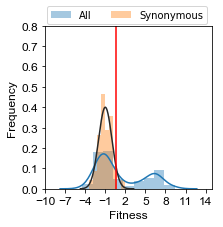

In [16]:
#The following graph generates a distribution of fitness effects for the scored mutations

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

#df_new_B_syn = df_new_B.loc[df_new_B.Non_Syn_Mutations.str.find('SYN') >= 0]
mu_10, sigma_10 = stats.norm.fit(df_new_B_syn.ten_fitness)
plt.figure(figsize=(3,3))
sns.distplot(df_new_B.hundred_fitness, label='All');
sns.distplot(df_new_B_syn.hundred_fitness, kde=False, fit=stats.norm, label='Synonymous')
plt.axvline(x = mu_10+2.56*sigma_10, color = 'red')
plt.legend(ncol = 2, bbox_to_anchor = [1,1.15])
plt.xlabel('Fitness', fontname = 'Arial', fontsize = 12)
plt.ylabel('Frequency', fontname = 'Arial', fontsize = 12)
plt.xlim([-10,15])
plt.ylim([0,0.8])

plt.xticks(np.arange(-10,15,3),fontname = 'Arial', fontsize = 12);
plt.yticks(fontname = 'Arial', fontsize = 12);
plt.savefig('Fitness_Distribution_100.svg', format = 'svg', dpi = 300)

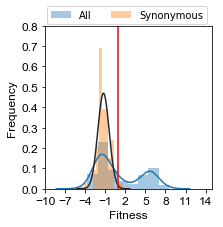

In [17]:
#The following graph generates a distribution of fitness effects for the scored mutations

plt.figure(figsize=(3,3))
sns.distplot(df_new_B.fifty_fitness, label='All');

sns.distplot(df_new_B_syn.fifty_fitness, kde=False, fit=stats.norm, label='Synonymous')
mu_50, sigma_50 = stats.norm.fit(df_new_B_syn.fifty_fitness)
plt.axvline(x = mu_50+2.56*sigma_50, color = 'red')
plt.legend(ncol = 2, bbox_to_anchor = [1,1.15])
plt.xlabel('Fitness', fontname = 'Arial', fontsize = 12)
plt.ylabel('Frequency', fontname = 'Arial', fontsize = 12)
plt.xlim([-10,15])
plt.ylim([0,0.8])

plt.xticks(np.arange(-10,15,3),fontname = 'Arial', fontsize = 12);
plt.yticks(fontname = 'Arial', fontsize = 12);
plt.savefig('Fitness_Distribution_50.svg', format = 'svg', dpi = 300)

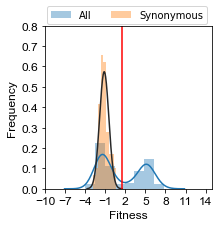

In [18]:
#The following graph generates a distribution of fitness effects for the scored mutations

plt.figure(figsize=(3,3))
sns.distplot(df_new_B.ten_fitness, label='All');
sns.distplot(df_new_B_syn.ten_fitness, kde=False, fit=stats.norm, label='Synonymous')
mu_100, sigma_100 = stats.norm.fit(df_new_B_syn.hundred_fitness)
plt.axvline(x = mu_100+2.56*sigma_100, color = 'red')
plt.legend(ncol = 2, bbox_to_anchor = [1,1.15])
plt.xlabel('Fitness', fontname = 'Arial', fontsize = 12)
plt.ylabel('Frequency', fontname = 'Arial', fontsize = 12)
plt.xlim([-10,15])
plt.ylim([0,0.8])
plt.xticks(np.arange(-10,15,3),fontname = 'Arial', fontsize = 12);
plt.yticks(fontname = 'Arial', fontsize = 12);
plt.savefig('Fitness_Distribution_10.svg', format = 'svg', dpi = 300)

In [19]:
#identify single mutants from the population and take mean
df_unique_single = df_new_B.loc[df_new_B.No_Non_Syn == 1]
df_unique_single = df_unique_single.loc[df_unique_single.Non_Syn_Mutations.str.find('SYN') < 0]
df_unique_single = df_unique_single.loc[df_unique_single.Non_Syn_Mutations.str.find('WT') < 0]

df_unique_single = df_unique_single.assign(Position = pd.to_numeric(df_unique_single.Non_Syn_Mutations.str[1:-1]))
print mu_100, sigma_100 
print mu_50, sigma_50
print mu_10, sigma_10

-0.9914862931673156 0.9971341671115369
-1.260545066389997 0.8509490010930617
-1.1484233187716772 0.6946656149100032


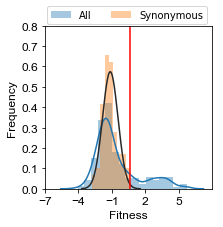

In [20]:
#The following graph generates a distribution of fitness effects for the scored mutations

plt.figure(figsize=(3,3))
sns.distplot(df_unique_single.ten_fitness, label='All');

sns.distplot(df_new_B_syn.ten_fitness, kde=False, fit=stats.norm, label='Synonymous')
plt.axvline(x = mu_10+2.56*sigma_10, color = 'red')
plt.legend(ncol = 2, bbox_to_anchor = [1,1.15])
plt.xlabel('Fitness', fontname = 'Arial', fontsize = 12)
plt.ylabel('Frequency', fontname = 'Arial', fontsize = 12)
plt.xlim([-7,8])
plt.ylim([0,0.8])
plt.xticks(np.arange(-7,8,3),fontname = 'Arial', fontsize = 12);
plt.yticks(fontname = 'Arial', fontsize = 12);
plt.savefig('Fitness_Distribution_single_10.svg', format = 'svg', dpi = 300)

In [22]:
print len(df_unique_single.loc[df_unique_single.ten_fitness >= mu_10+2.56*sigma_10])

47


24


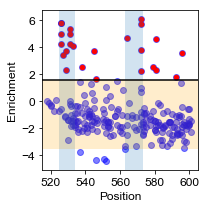

In [23]:
df_top_100 = df_unique_single.loc[df_unique_single.hundred_fitness >= mu_100+2.56*sigma_100]
df_top_100 = df_top_100.set_index('Non_Syn_Mutations')
print len(df_top_100)
fig, ax = plt.subplots(figsize=(3,3))
plt.axvspan(525, 534, alpha=0.2, label = 'Known Resistance Zone')
plt.axvspan(563, 573, alpha=0.2, label = 'Known Resistance Zone')
plt.axhspan(mu_100-2.56*sigma_100, mu_100+2.56*sigma_100, \
            facecolor = 'orange',alpha=0.2, label = 'Known Resistance Zone')
ax.scatter(df_unique_single.Position, df_unique_single.hundred_fitness, color = 'blue', alpha = 0.5)
df_top_100.plot('Position','hundred_fitness', kind = 'scatter', ax= ax, color='red')
plt.axhline(y = mu_100+2.56*sigma_100, color = 'black')
plt.xlabel('Position', fontname = 'Arial', fontsize = 12)
plt.ylabel('Enrichment', fontname = 'Arial', fontsize = 12)
plt.xlim(515,605)
plt.xticks(fontname = 'Arial', fontsize = 12);
plt.yticks(fontname = 'Arial', fontsize = 12);
plt.tight_layout()
plt.savefig('Mutation_by_position_100.svg', format = 'svg', dpi = 300)

26


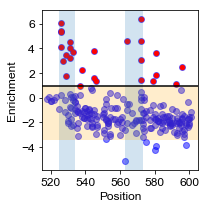

In [24]:
df_top_50 = df_unique_single.loc[df_unique_single.fifty_fitness >= mu_50+2.56*sigma_50]
df_top_50 = df_top_50.set_index('Non_Syn_Mutations')
print len(df_top_50)
fig, ax = plt.subplots(figsize=(3,3))
plt.axvspan(525, 534, alpha=0.2, label = 'Known Resistance Zone')
plt.axvspan(563, 573, alpha=0.2, label = 'Known Resistance Zone')
plt.axhspan(mu_50-2.56*sigma_50, mu_50+2.56*sigma_50, \
            facecolor = 'orange',alpha=0.2, label = 'Known Resistance Zone')
ax.scatter(df_unique_single.Position, df_unique_single.fifty_fitness, color = 'blue', alpha = 0.5)
df_top_50.plot('Position','fifty_fitness', kind = 'scatter', ax= ax, color='red')
plt.axhline(y = mu_50+2.56*sigma_50, color = 'black')
plt.xlabel('Position', fontname = 'Arial', fontsize = 12)
plt.ylabel('Enrichment', fontname = 'Arial', fontsize = 12)
plt.xlim(515,605)
plt.xticks(fontname = 'Arial', fontsize = 12);
plt.yticks(fontname = 'Arial', fontsize = 12);
plt.tight_layout()
plt.savefig('Mutation_by_position_50.svg', format = 'svg', dpi = 300)

47


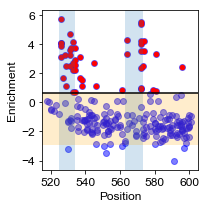

In [25]:
df_top_10 = df_unique_single.loc[df_unique_single.ten_fitness >= mu_10+2.56*sigma_10]
df_top_10 = df_top_10.set_index('Non_Syn_Mutations')
print len(df_top_10)
fig, ax = plt.subplots(figsize=(3,3))
plt.axvspan(525, 534, alpha=0.2, label = 'Known Resistance Zone')
plt.axvspan(563, 573, alpha=0.2, label = 'Known Resistance Zone')
plt.axhspan(mu_10-2.56*sigma_10, mu_10+2.56*sigma_10, \
            facecolor = 'orange',alpha=0.2, label = 'Known Resistance Zone')
ax.scatter(df_unique_single.Position, df_unique_single.ten_fitness, color = 'blue', alpha = 0.5)
df_top_10.plot('Position','ten_fitness', kind = 'scatter', ax= ax, color='red')
plt.axhline(y = mu_10+2.56*sigma_10, color = 'black')
plt.xlabel('Position', fontname = 'Arial', fontsize = 12)
plt.ylabel('Enrichment', fontname = 'Arial', fontsize = 12)
plt.xlim(515,605)
plt.xticks(fontname = 'Arial', fontsize = 12);
plt.yticks(fontname = 'Arial', fontsize = 12);
plt.tight_layout()
plt.savefig('Mutation_by_position_10.svg', format = 'svg', dpi = 300)

In [26]:
df_top_10 = df_new_B.loc[df_new_B.ten_fitness >= mu_10+2.56*sigma_10]
df_top_50 = df_new_B.loc[df_new_B.fifty_fitness >= mu_50+2.56*sigma_50]
df_top_100 = df_new_B.loc[df_new_B.hundred_fitness >= mu_100+2.56*sigma_100]


In [27]:
"""
The following code evaluated double mutants
"""
df_unique_double = df_new_B.loc[df_new_B.No_Non_Syn == 2]
#Make a new column with list of individual mutations
df_unique_double = df_unique_double.assign(Mutations = df_unique_double.index.values)
#Get the first mutation from the double mutant
df_unique_double = df_unique_double.assign(Mutation1 = df_unique_double.Non_Syn_Mutations.str.split(",",expand=True)[0])
#Get the second mutation from the double mutant
df_unique_double = df_unique_double.assign(Mutation2 = df_unique_double.Non_Syn_Mutations.str.split(",",expand=True)[1])
#Get the posiiton for the first mutation
df_unique_double = df_unique_double.assign(Position1 = df_unique_double.Mutation1.str[1:-1])
#Get the posiiton for the second mutation
df_unique_double = df_unique_double.assign(Position2 = df_unique_double.Mutation2.str[1:-1])

In [28]:
"""
We will use the following blocks of code to measure 
epistasis at different concentrations of rifampicin
"""
#For the double mutant we only pull the data for selection at 10 ug/mL
df_unique_double_ten = df_unique_double[['Non_Syn_Mutations','pre','ten',\
                                         'ten_fitness','ten_error','Mutation1','Mutation2']]
#For the single mutant we only pull the data for selection at 10 ug/mL
df_unique_single_ten = df_unique_single[['Non_Syn_Mutations','Non_Syn_Mutations','pre','ten',\
                                         'ten_fitness','ten_error']]
#For the single mutant data we rename the columns to join the data to Mutation 1 for 10 ug/mL
df_unique_single_ten.columns = ['Mutation1','Mutation1A','pre1','ten1',\
                                         'ten_fitness1','ten_error1']
df_unique_double_ten = df_unique_double_ten.join(df_unique_single_ten.set_index('Mutation1'), on='Mutation1')
#For the single mutant data we rename the columns to join the data to Mutation 2 for 10 ug/mL
df_unique_single_ten.columns = ['Mutation2','Mutation2A','pre2','ten2',\
                                         'ten_fitness2','ten_error2']
df_unique_double_ten = df_unique_double_ten.join(df_unique_single_ten.set_index('Mutation2'), on='Mutation2')

#For the single mutant data we rename the columns to join the data to Mutation 2 for 10 ug/mL
df_unique_double_ten['fitness_sum'] = df_unique_double_ten['ten_fitness1'] + df_unique_double_ten['ten_fitness2']
df_unique_double_ten['fitness_sum_error'] = np.sqrt(np.square(df_unique_double_ten['ten_error1'])\
                                         + np.square(df_unique_double_ten['ten_error2']))

df_unique_double_ten = df_unique_double_ten.dropna()
condition_B = (df_unique_double_ten.pre >= pre_filter)|\
(df_unique_double_ten.ten >= ten_filter)
df_unique_double_ten = df_unique_double_ten.loc[condition_B]

condition_B = (df_unique_double_ten.pre1 >= pre_filter)|\
(df_unique_double_ten.ten1 >= ten_filter)
df_unique_double_ten = df_unique_double_ten.loc[condition_B]

condition_B = (df_unique_double_ten.pre2 >= pre_filter)|\
(df_unique_double_ten.ten2 >= ten_filter)
df_unique_double_ten = df_unique_double_ten.loc[condition_B]

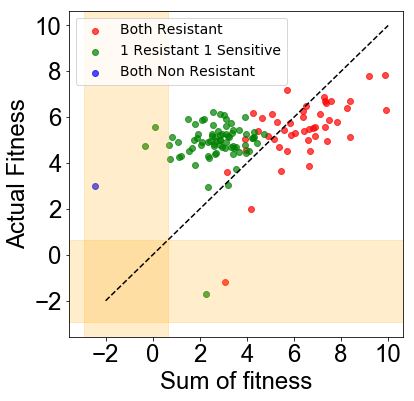

In [29]:
plt.figure(figsize=(6,6))

df_positives_10 = df_unique_double_ten.loc[(df_unique_double_ten.ten_fitness1 > mu_10+2.56*sigma_10)\
                                           & (df_unique_double_ten.ten_fitness2 > mu_10+2.56*sigma_10)]

plt.scatter(df_positives_10.fitness_sum, df_positives_10.ten_fitness, color = 'red',\
            alpha = 0.7, label = 'Both Resistant')

df_neutral_10 = df_unique_double_ten.loc[((df_unique_double_ten.ten_fitness1 > mu_10+2.56*sigma_10) &\
                                         (df_unique_double_ten.ten_fitness2 < mu_10+2.56*sigma_10))|
                                        ((df_unique_double_ten.ten_fitness1 < mu_10+2.56*sigma_10) &\
                                         (df_unique_double_ten.ten_fitness2 > mu_10+2.56*sigma_10))]
plt.scatter(df_neutral_10.fitness_sum, df_neutral_10.ten_fitness, color = 'green',\
            alpha = 0.7, label = '1 Resistant 1 Sensitive')

df_neutral_double_10 = df_unique_double_ten.loc[((df_unique_double_ten.ten_fitness1 < mu_10+2.56*sigma_10) &\
                                         (df_unique_double_ten.ten_fitness2 < mu_10+2.56*sigma_10))]

plt.scatter(df_neutral_double_10.fitness_sum, df_neutral_double_10.ten_fitness,\
            color = 'blue',  alpha = 0.7, label = 'Both Non Resistant')

plt.plot([-2,0,1,2,3,4,5,8,10],[-2,0,1,2,3,4,5,8,10], '--', color = 'black')

plt.axhspan(mu_10+2.56*sigma_10, mu_10-2.56*sigma_10, alpha = 0.2, color = 'orange')
plt.axvspan(mu_10+2.56*sigma_10, mu_10-2.56*sigma_10, alpha = 0.2, color = 'orange')

plt.xlabel('Sum of fitness', fontname = 'Arial', fontsize = 24)
plt.ylabel('Actual Fitness', fontname = 'Arial', fontsize = 24)
plt.xticks(fontname = 'Arial', fontsize = 24)
plt.yticks(fontname = 'Arial', fontsize = 24)

plt.legend(fontsize = 14)
plt.savefig('Actual versus Predicted 10.svg',format = 'svg', dpi = 300)

In [30]:
"""
We will use the following blocks of code to measure 
epistasis at different concentrations of rifampicin
"""
df_unique_double_fifty = df_unique_double[['Non_Syn_Mutations','pre','fifty',\
                                         'fifty_fitness','fifty_error','Mutation1','Mutation2']]

df_unique_single_fifty = df_unique_single[['Non_Syn_Mutations','Non_Syn_Mutations','pre','fifty',\
                                         'fifty_fitness','fifty_error']]
df_unique_single_fifty.columns = ['Mutation1','Mutation1A','pre1','fifty1',\
                                         'fifty_fitness1','fifty_error1']
df_unique_double_fifty = df_unique_double_fifty.join(df_unique_single_fifty.set_index('Mutation1'), on='Mutation1')
df_unique_single_fifty.columns = ['Mutation2','Mutation2A','pre2','fifty2',\
                                         'fifty_fitness2','fifty_error2']
df_unique_double_fifty = df_unique_double_fifty.join(df_unique_single_fifty.set_index('Mutation2'), on='Mutation2')
df_unique_double_fifty['fitness_sum'] = df_unique_double_fifty['fifty_fitness1'] + df_unique_double_fifty['fifty_fitness2']
df_unique_double_fifty['fitness_sum_error'] = np.sqrt(np.square(df_unique_double_fifty['fifty_error1'])\
                                         + np.square(df_unique_double_fifty['fifty_error2']))

df_unique_double_fifty = df_unique_double_fifty.dropna()

condition_B = (df_unique_double_fifty.pre >= pre_filter)|\
(df_unique_double_fifty.fifty >= fifty_filter)
df_unique_double_fifty = df_unique_double_fifty.loc[condition_B]

condition_B = (df_unique_double_fifty.pre1 >= pre_filter)|\
(df_unique_double_fifty.fifty1 >= fifty_filter)
df_unique_double_fifty = df_unique_double_fifty.loc[condition_B]

condition_B = (df_unique_double_fifty.pre2 >= pre_filter)|\
(df_unique_double_fifty.fifty2 >= fifty_filter)
df_unique_double_fifty = df_unique_double_fifty.loc[condition_B]

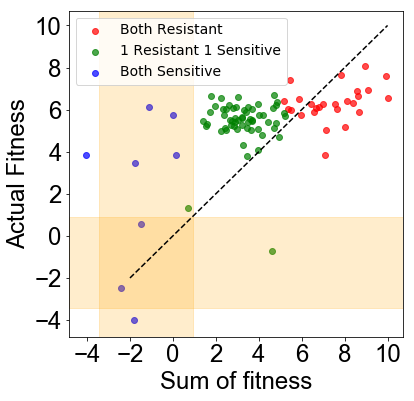

In [31]:
plt.figure(figsize=(6,6))

df_positives_50 = df_unique_double_fifty.loc[(df_unique_double_fifty.fifty_fitness1 > mu_50+2.56*sigma_50)\
                                           & (df_unique_double_fifty.fifty_fitness2 > mu_50+2.56*sigma_50)]

plt.scatter(df_positives_50.fitness_sum, df_positives_50.fifty_fitness, color = 'red',\
            alpha = 0.7, label = 'Both Resistant')

df_neutral_50 = df_unique_double_fifty.loc[((df_unique_double_fifty.fifty_fitness1 > mu_50+2.56*sigma_50) &\
                                         (df_unique_double_fifty.fifty_fitness2 < mu_50+2.56*sigma_50))|
                                        ((df_unique_double_fifty.fifty_fitness1 < mu_50+2.56*sigma_50) &\
                                         (df_unique_double_fifty.fifty_fitness2 > mu_50+2.56*sigma_50))]
plt.scatter(df_neutral_50.fitness_sum, df_neutral_50.fifty_fitness, color = 'green',\
            alpha = 0.7, label = '1 Resistant 1 Sensitive')

df_neutral_double_50 = df_unique_double_fifty.loc[((df_unique_double_fifty.fifty_fitness1 < mu_50+2.56*sigma_50) &\
                                         (df_unique_double_fifty.fifty_fitness2 < mu_50+2.56*sigma_50))]

plt.scatter(df_neutral_double_50.fitness_sum, df_neutral_double_50.fifty_fitness,\
            color = 'blue',  alpha = 0.7, label = 'Both Sensitive')

plt.plot([-2,0,1,2,3,4,5,8,10],[-2,0,1,2,3,4,5,8,10], '--', color = 'black')

plt.axhspan(mu_50+2.56*sigma_50, mu_50-2.56*sigma_50, alpha = 0.2, color = 'orange')
plt.axvspan(mu_50+2.56*sigma_50, mu_50-2.56*sigma_50, alpha = 0.2, color = 'orange')

plt.xlabel('Sum of fitness', fontname = 'Arial', fontsize = 24)
plt.ylabel('Actual Fitness', fontname = 'Arial', fontsize = 24)
plt.xticks(fontname = 'Arial', fontsize = 24)
plt.yticks(fontname = 'Arial', fontsize = 24)

plt.legend(fontsize = 14)
plt.savefig('Actual versus Predicted 50.svg',format = 'svg', dpi = 300)

In [32]:
"""
We will use the following blocks of code to measure 
epistasis at different concentrations of rifampicin
"""
df_unique_double_hundred = df_unique_double[['Non_Syn_Mutations','pre','hundred',\
                                         'hundred_fitness','hundred_error','Mutation1','Mutation2']]

df_unique_single_hundred = df_unique_single[['Non_Syn_Mutations','Non_Syn_Mutations','pre','hundred',\
                                         'hundred_fitness','hundred_error']]
df_unique_single_hundred.columns = ['Mutation1','Mutation1A','pre1','hundred1',\
                                         'hundred_fitness1','hundred_error1']
df_unique_double_hundred = df_unique_double_hundred.join(df_unique_single_hundred.set_index('Mutation1'), on='Mutation1')
df_unique_single_hundred.columns = ['Mutation2','Mutation2A','pre2','hundred2',\
                                         'hundred_fitness2','hundred_error2']
df_unique_double_hundred = df_unique_double_hundred.join(df_unique_single_hundred.set_index('Mutation2'), on='Mutation2')
df_unique_double_hundred['fitness_sum'] = df_unique_double_hundred['hundred_fitness1'] + df_unique_double_hundred['hundred_fitness2']
df_unique_double_hundred['fitness_sum_error'] = np.sqrt(np.square(df_unique_double_hundred['hundred_error1'])\
                                         + np.square(df_unique_double_hundred['hundred_error2']))

df_unique_double_hundred = df_unique_double_hundred.dropna()
condition_B = (df_unique_double_hundred.pre >= pre_filter)|\
(df_unique_double_hundred.hundred >= hundred_filter)
df_unique_double_hundred = df_unique_double_hundred.loc[condition_B]

condition_B = (df_unique_double_hundred.pre1 >= pre_filter)|\
(df_unique_double_hundred.hundred1 >= hundred_filter)
df_unique_double_hundred = df_unique_double_hundred.loc[condition_B]

condition_B = (df_unique_double_hundred.pre2 >= pre_filter)|\
(df_unique_double_hundred.hundred2 >= hundred_filter)
df_unique_double_hundred = df_unique_double_hundred.loc[condition_B]

In [33]:
df_unique_double_hundred = df_unique_double_hundred.assign(Sign_p_value = stats.norm.sf(abs((df_unique_double_hundred.fitness_sum - df_unique_double_hundred.hundred_fitness)/\
                            np.sqrt((np.square(df_unique_double_hundred.fitness_sum_error) + \
                                     np.square(df_unique_double_hundred.hundred_error))))))
mask = (df_unique_double_hundred.hundred_fitness>df_unique_double_hundred.fitness_sum)\
        & (df_unique_double_hundred.Sign_p_value <= 0.01)
df_unique_double_hundred.loc[mask, 'Sign'] = 'Positive'
mask = (df_unique_double_hundred.hundred_fitness<df_unique_double_hundred.fitness_sum)\
        & (df_unique_double_hundred.Sign_p_value <= 0.01)
df_unique_double_hundred.loc[mask, 'Sign'] = 'Negative'
mask = df_unique_double_hundred.Sign_p_value > 0.01
df_unique_double_hundred.loc[mask, 'Sign'] = 'Neutral'
df_unique_double_hundred.Sign.value_counts(normalize=True).values[1]*100

24.444444444444443

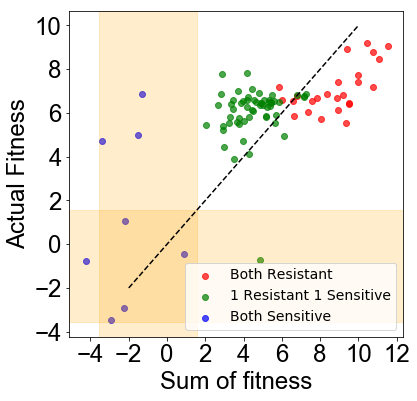

In [34]:
plt.figure(figsize=(6,6))

df_positives_100 = df_unique_double_hundred.loc[(df_unique_double_hundred.hundred_fitness1 > mu_100+2.56*sigma_100)\
                                           & (df_unique_double_hundred.hundred_fitness2 > mu_100+2.56*sigma_100)]

plt.scatter(df_positives_100.fitness_sum, df_positives_100.hundred_fitness, color = 'red',\
            alpha = 0.7, label = 'Both Resistant')

df_neutral_100 = df_unique_double_hundred.loc[((df_unique_double_hundred.hundred_fitness1 > mu_100+2.56*sigma_100) &\
                                         (df_unique_double_hundred.hundred_fitness2 < mu_100+2.56*sigma_100))|
                                        ((df_unique_double_hundred.hundred_fitness1 < mu_100+2.56*sigma_100) &\
                                         (df_unique_double_hundred.hundred_fitness2 > mu_100+2.56*sigma_100))]
plt.scatter(df_neutral_100.fitness_sum, df_neutral_100.hundred_fitness, color = 'green',\
            alpha = 0.7, label = '1 Resistant 1 Sensitive')

df_neutral_double_100 = df_unique_double_hundred.loc[((df_unique_double_hundred.hundred_fitness1 < mu_100+2.56*sigma_100) &\
                                         (df_unique_double_hundred.hundred_fitness2 < mu_100+2.56*sigma_100))]

plt.scatter(df_neutral_double_100.fitness_sum, df_neutral_double_100.hundred_fitness,\
            color = 'blue',  alpha = 0.7, label = 'Both Sensitive')

plt.plot([-2,0,1,2,3,4,5,8,10],[-2,0,1,2,3,4,5,8,10], '--', color = 'black')

plt.axhspan(mu_100+2.56*sigma_100, mu_100-2.56*sigma_100, alpha = 0.2, color = 'orange')
plt.axvspan(mu_100+2.56*sigma_100, mu_100-2.56*sigma_100, alpha = 0.2, color = 'orange')

plt.xlabel('Sum of fitness', fontname = 'Arial', fontsize = 24)
plt.ylabel('Actual Fitness', fontname = 'Arial', fontsize = 24)
plt.xticks(fontname = 'Arial', fontsize = 24)
plt.yticks(fontname = 'Arial', fontsize = 24)

plt.legend(fontsize = 14)
plt.savefig('Actual versus Predicted 100.svg',format = 'svg', dpi = 300)
condition_B = (df_new_B.pre >= pre_filter)| (df_new_B.fifty >= hundred_filter)
df_unique_double_hundred = df_unique_double_hundred.loc[condition_B]

In [35]:
df_unique_double_ten = df_unique_double_ten.assign(Epistasis = 
                                                  df_unique_double_ten.ten_fitness-\
                                                   df_unique_double_ten.ten_fitness1-\
                                                  df_unique_double_ten.ten_fitness2)

df_unique_double_fifty = df_unique_double_fifty.assign(Epistasis = 
                                                  df_unique_double_fifty.fifty_fitness-\
                                                   df_unique_double_fifty.fifty_fitness1-\
                                                  df_unique_double_fifty.fifty_fitness2)

df_unique_double_hundred = df_unique_double_hundred.assign(Epistasis = 
                                                  df_unique_double_hundred.hundred_fitness-\
                                                   df_unique_double_hundred.hundred_fitness1-\
                                                  df_unique_double_hundred.hundred_fitness2)

In [36]:
df_epistasis_comp = df_unique_double_ten[['Non_Syn_Mutations','Epistasis']].set_index('Non_Syn_Mutations')
df_two = df_unique_double_fifty[['Non_Syn_Mutations','Epistasis']].set_index('Non_Syn_Mutations')
df_two.columns = ['Epistasis_fifty']
df_epistasis_comp = df_epistasis_comp.join(df_two, how='outer')
df_two = df_unique_double_hundred[['Non_Syn_Mutations','Epistasis']].set_index('Non_Syn_Mutations')
df_two.columns = ['Epistasis_hundred']
df_epistasis_comp = df_epistasis_comp.join(df_two, how='outer')
df_epistasis_comp = df_epistasis_comp.dropna()


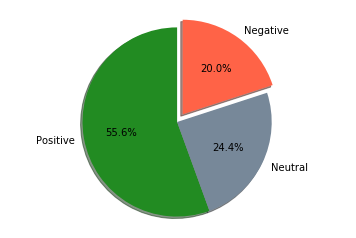

In [40]:
df_unique_double_hundred = df_unique_double_hundred.assign(Sign_p_value = stats.norm.sf(abs((df_unique_double_hundred.fitness_sum - df_unique_double_hundred.hundred_fitness)/\
                            np.sqrt((np.square(df_unique_double_hundred.fitness_sum_error) + \
                                     np.square(df_unique_double_hundred.hundred_error))))))
mask = (df_unique_double_hundred.hundred_fitness>df_unique_double_hundred.fitness_sum)\
        & (df_unique_double_hundred.Sign_p_value <= 0.01)
df_unique_double_hundred.loc[mask, 'Sign'] = 'Positive'
mask = (df_unique_double_hundred.hundred_fitness<df_unique_double_hundred.fitness_sum)\
        & (df_unique_double_hundred.Sign_p_value <= 0.01)
df_unique_double_hundred.loc[mask, 'Sign'] = 'Negative'
mask = df_unique_double_hundred.Sign_p_value > 0.01
df_unique_double_hundred.loc[mask, 'Sign'] = 'Neutral'
df_unique_double_hundred.Sign.value_counts(normalize=True).values[1]*100
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Positive','Neutral','Negative'
sizes = [df_unique_double_hundred.Sign.value_counts(normalize=True).values[0]*100,\
        df_unique_double_hundred.Sign.value_counts(normalize=True).values[1]*100,\
        df_unique_double_hundred.Sign.value_counts(normalize=True).values[2]*100,]
explode = (0,0,0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, colors = ['forestgreen','lightslategray','tomato'])
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.savefig('Mag_Epistasis_100.svg', format = 'svg', dpi = 300)

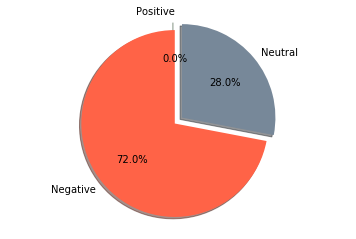

In [41]:
df_positives_100 = df_unique_double_hundred.loc[(df_unique_double_hundred.hundred_fitness1 > mu_100+2.56*sigma_100)\
                                           & (df_unique_double_hundred.hundred_fitness2 > mu_100+2.56*sigma_100)]
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Negative', 'Neutral','Positive'
sizes = [df_positives_100.Sign.value_counts(normalize=True).values[0]*100,\
        df_positives_100.Sign.value_counts(normalize=True).values[1]*100,\
        0]
explode = (0,0.1,0.1) 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, colors = ['tomato','lightslategray','forestgreen'])
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.savefig('Mag_Epistasis_Positives_100.svg', format = 'svg', dpi = 300)

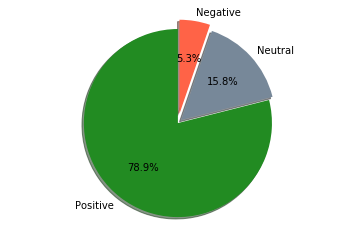

In [42]:
df_neutral_100 = df_unique_double_hundred.loc[((df_unique_double_hundred.hundred_fitness1 > mu_100+2.56*sigma_100) &\
                                         (df_unique_double_hundred.hundred_fitness2 < mu_100+2.56*sigma_100))|
                                        ((df_unique_double_hundred.hundred_fitness1 < mu_100+2.56*sigma_100) &\
                                         (df_unique_double_hundred.hundred_fitness2 > mu_100+2.56*sigma_100))]

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Positive', 'Neutral','Negative'
sizes = [df_neutral_100.Sign.value_counts(normalize=True).values[0]*100,\
        df_neutral_100.Sign.value_counts(normalize=True).values[1]*100,\
        df_neutral_100.Sign.value_counts(normalize=True).values[2]*100]
explode = (0,0.05,0.1) 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, colors = ['forestgreen','lightslategray','tomato'])
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.savefig('Mag_Epistasis_Neutral_100.svg', format = 'svg', dpi = 300)